# **Facial Landmarks Detection**



In this Notebook, I have implemented Facial landmarks(key points) detection system using Convolution Neural networks and image processing techniques. Facial landmark detection is regression kind of task where output is a set of values representing positions in the image rather than one hot encodings that we use generally for classification task.This project uses Keras with TensorFlow in the backend, opencv and dlib libraries. Once we train the landmarks detection model, it will be used for for testing on real time images. For any task of processing facial features on real-time images, first step will be detecing the faces in the image. Face  detection task is achieved by using dlib's implementation. Once faces are detected, we will feed them to the trained model to predict the landmarks. This complete project is seperated into three parts: first part involves loading dataset and prepprocessing it to convert into tensors. Second part is about training and testing CNN model with the data. Third part includes preprocessing real-time image to detect faces and feeding it to trained model to predict landmarks.


## **Part1:**
This part inlcudes collecting data and processing it as required by the model. Collected Kaggle's facial landmark detection dataset that can be found [here](https://Kaggle.com/c/facial-keypoints-detection/data). This dataset has a training file which contains each image with (96 ,96) size and 30 landmarks in csv format. Test file contains only image data and we need to predict 
landmarks for the images. Both files can loaded directly if you are running notebook locally. If you are using Colaboratory, you can load the files from google drive using thier api. Once we load the files, we need to arrange the data into Tensors either (m,h,w,c) or (c,h,w,m) format as keras api accepts inputs of these formats.


In [6]:
!pip install pydrive
from pandas import DataFrame, read_csv
import matplotlib.pyplot as plt
import pandas as pd 
import os
from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive
from google.colab import auth
from oauth2client.client import GoogleCredentials
import numpy as np
from google.colab import files
from sklearn.utils import shuffle

def getFileFromGDrive(train = True):
  # Authenticate and create the PyDrive client.
  auth.authenticate_user()
  gauth = GoogleAuth()
  gauth.credentials = GoogleCredentials.get_application_default()
  drive = GoogleDrive(gauth)

  # Load training files from drive, eed to provide <File_ID> thats has train and test files
  file_list = drive.ListFile({'q': "'1kUOrh7_fUHM1T76e1GGY5KJ2YbvTFyYR' in parents and trashed=false"}).GetList()
  for file1 in file_list:
    print('title: %s, id: %s' % (file1['title'], file1['id']))
  train_downloaded = drive.CreateFile({'id': file_list[1]['id']})
  train_downloaded.GetContentFile('test.csv')
  test_downloaded = drive.CreateFile({'id': file_list[0]['id']})
  test_downloaded.GetContentFile('training.csv') 
   # allows you to temporarily load your file in the notebook VM
  
  file_name = file_list[0]['title'] if train else file_list[1]['title']
  df = pd.read_csv(file_name)
  return df

def getFileFromLocal():
  uploaded = files.upload()
  df = pd.read_csv("localFilePath")
  return df


def loadData(train=True):
  dFrame = getFileFromGDrive(train) #Change this to load file from local  
   # The Image column has pixel values separated by space convert
   # the values to numpy arrays
  dFrame['Image'] = dFrame['Image'].apply(lambda row: np.fromstring(row, sep=' '))
    
  dFrame = dFrame.dropna()  # drop all rows that have missing values in them
  X = np.vstack(dFrame['Image'].values) / 255.  # scale pixel values to [0, 1]
  X = X.astype(np.float32)
  X = X.reshape(-1, 96, 96, 1) # return each images as 96 x 96 x 1
  
  if train:
    y = dFrame[dFrame.columns[:-1]].values
    y = (y - 48) / 48  # scale target coordinates to [-1, 1]
    X, y = shuffle(X, y, random_state=42)  # shuffle train data
    y = y.astype(np.float32)
  else:
    y = None

  return X, y


def plotData(image, landmarks, figure):
    figure.imshow(np.squeeze(image), cmap='gray') # plot the image
    landmarks = landmarks * 48 + 48 # undo the normalization
    # Plot the keypoints
    figure.scatter(landmarks[0::2],landmarks[1::2],marker='o',c='r',s=10)

if __name__ == '__main__':
    loadData(True)
#Load the data once from the drive so that it will be loaded into VM and no need it 
#again. comment out last two lines once downloaded.

title: training.csv, id: 1a9nK32hUh4Vq8KVA-B3cb1PLIkEWjnc6
title: test.csv, id: 1ftC1Ol365k5pjF1gl1y7akLKAJDnWk_H


## **Part2:**

Here, we will create CNN architecture usig Keras sequential model. Created a VGG-16 style architecture with 5 covolution layers and 8 layers in total including dense layers. All convolution layers will have filters with same size and follows power of 2 increaments in the no of filters in the next layer. Intermediate layers will have relu activations. Final layer will have only linear activation as we are not predicting the probabilities of one hot encodings.

Using TensorFlow backend.


title: training.csv, id: 1a9nK32hUh4Vq8KVA-B3cb1PLIkEWjnc6
title: test.csv, id: 1ftC1Ol365k5pjF1gl1y7akLKAJDnWk_H
Input data shape == (2140, 96, 96, 1)
Output shape == (2140, 30)
output key points: [ 0.4330242  -0.21624877 -0.3466828  -0.3463223   0.25858903 -0.1851669
  0.5810062  -0.1878271  -0.16970447 -0.23996718 -0.5165956  -0.3564843
  0.29375893 -0.24669313  0.74820185 -0.32774875 -0.07298451 -0.2971868
 -0.6224353  -0.51643556 -0.0278047   0.24908654  0.334971    0.3931978
 -0.4643302   0.31000873 -0.06167792  0.52398473 -0.08612007  0.5925943 ]
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 94, 94, 16)        160       
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 47, 47, 16)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 45, 45, 

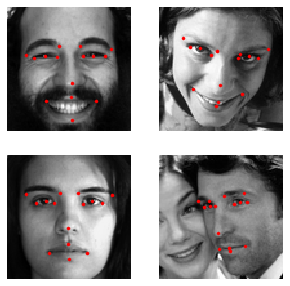

In [7]:
from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D, Dropout
from keras.layers import Flatten, Dense
from keras.layers.normalization import BatchNormalization
import matplotlib.pyplot  as plt
%matplotlib inline

# Load training set
train_input,train_output = loadData(True)
print("Input data shape == {}".format(train_input.shape))
print("Output shape == {}".format(train_output.shape))
print("output key points: {}".format(train_output[1]))


# Plot four taining images
fig = plt.figure(figsize=(5,5))
for i in range(4):
    figure = fig.add_subplot(2, 2, i + 1, xticks=[], yticks=[])
    plotData(train_input[i], train_output[i], figure)
    
#VGG-16 Style Architecture

model  =  Sequential()
model.add(Conv2D(filters=16, kernel_size=3, activation = 'relu', input_shape=(96,96,1)))
model.add(MaxPooling2D(pool_size=2))

model.add(Conv2D(filters=32, kernel_size=3, activation='relu'))
model.add(MaxPooling2D(pool_size=2))

model.add(Conv2D(filters=64, kernel_size=3, activation='relu'))
model.add(MaxPooling2D(pool_size=2))

model.add(Conv2D(filters=128, kernel_size=3, activation='relu'))
model.add(MaxPooling2D(pool_size=2))

model.add(Conv2D(filters=256, kernel_size=3, activation='relu'))
model.add(MaxPooling2D(pool_size=2))

model.add(Flatten())

model.add(Dense(512, activation='relu'))
model.add(Dropout(0.2))


model.add(Dense(30))
    
model.summary()

 > Now, we will compile the model. Compilation involves specifying optimizer that minimizesthe  loss. Mean square error is choosen for loss function as our final layer outputs are linear activation outputs. If you are choosing mini batch training, need to specify batch size. Specifying  epochs or passes is important as it helps to get a better model by traversing various local optimums. We can also specify checkpointer to save the model after one or more no of passes. Verbose can be used to get logging information while training, parameter can modified to change the level of logging.






In [0]:
from keras.callbacks import ModelCheckpoint, History
from keras.optimizers import Adam

hist = History()
epochs = 50
#Choose in terms of power of 2
batch_size = 32  
filepath='model_weights.ckpt'

checkpointer = ModelCheckpoint(filepath, verbose=1, save_best_only=True, period=5)

#Compile the model
model.compile(optimizer='adam', loss='mse', metrics=['accuracy'])

history = model.fit(X_train, y_train, validation_split=0.2, callbacks = [checkpointer,hist],
         batch_size=batch_size, epochs=epochs, verbose=1)


#model.save('my_model.h5'),

Train on 1712 samples, validate on 428 samples
Epoch 1/50
1712/1712 [==============================] - 2s 1ms/step - loss: 0.0011 - acc: 0.8113 - val_loss: 0.0011 - val_acc: 0.7967
Epoch 2/50
1712/1712 [==============================] - 1s 698us/step - loss: 0.0010 - acc: 0.8107 - val_loss: 0.0011 - val_acc: 0.8201
Epoch 3/50
1712/1712 [==============================] - 1s 697us/step - loss: 9.7083e-04 - acc: 0.8265 - val_loss: 0.0012 - val_acc: 0.7897
Epoch 4/50
1712/1712 [==============================] - 1s 685us/step - loss: 9.8103e-04 - acc: 0.8277 - val_loss: 0.0011 - val_acc: 0.7850
Epoch 5/50
1712/1712 [==============================] - 1s 693us/step - loss: 9.3216e-04 - acc: 0.8289 - val_loss: 0.0011 - val_acc: 0.7991

Epoch 00005: val_loss improved from inf to 0.00111, saving model to model_weights.ckpt
Epoch 6/50
1712/1712 [==============================] - 1s 694us/step - loss: 8.9405e-04 - acc: 0.8189 - val_loss: 0.0011 - val_acc: 0.7874
Epoch 7/50
1712/1712 [=============

1712/1712 [==============================] - 1s 698us/step - loss: 8.2830e-04 - acc: 0.8154 - val_loss: 0.0011 - val_acc: 0.8224
Epoch 9/50
1712/1712 [==============================] - 1s 693us/step - loss: 8.3005e-04 - acc: 0.8242 - val_loss: 0.0011 - val_acc: 0.7850
Epoch 10/50
1712/1712 [==============================] - 1s 708us/step - loss: 8.2185e-04 - acc: 0.8370 - val_loss: 0.0013 - val_acc: 0.8294

Epoch 00010: val_loss did not improve from 0.00111
Epoch 11/50
1712/1712 [==============================] - 1s 694us/step - loss: 8.0686e-04 - acc: 0.8242 - val_loss: 0.0010 - val_acc: 0.8154
Epoch 12/50
1712/1712 [==============================] - 1s 693us/step - loss: 7.8631e-04 - acc: 0.8254 - val_loss: 0.0010 - val_acc: 0.8014
Epoch 13/50
1712/1712 [==============================] - 1s 695us/step - loss: 7.8317e-04 - acc: 0.8312 - val_loss: 0.0011 - val_acc: 0.8084
Epoch 14/50
1712/1712 [==============================] - 1s 690us/step - loss: 7.9493e-04 - acc: 0.8236 - val_loss:

1712/1712 [==============================] - 1s 686us/step - loss: 7.3323e-04 - acc: 0.8312 - val_loss: 0.0010 - val_acc: 0.8061
Epoch 17/50
1712/1712 [==============================] - 1s 689us/step - loss: 6.9551e-04 - acc: 0.8382 - val_loss: 0.0010 - val_acc: 0.8154
Epoch 18/50
1712/1712 [==============================] - 1s 690us/step - loss: 7.1977e-04 - acc: 0.8335 - val_loss: 0.0010 - val_acc: 0.8014
Epoch 19/50
1712/1712 [==============================] - 1s 684us/step - loss: 6.9074e-04 - acc: 0.8329 - val_loss: 0.0011 - val_acc: 0.7921
Epoch 20/50
1712/1712 [==============================] - 1s 685us/step - loss: 6.9615e-04 - acc: 0.8411 - val_loss: 0.0011 - val_acc: 0.8154

Epoch 00020: val_loss improved from 0.00111 to 0.00106, saving model to model_weights.ckpt
Epoch 21/50
1712/1712 [==============================] - 1s 686us/step - loss: 6.5130e-04 - acc: 0.8405 - val_loss: 0.0011 - val_acc: 0.8154
Epoch 22/50
1712/1712 [==============================] - 1s 688us/step - l

Epoch 24/50
1712/1712 [==============================] - 1s 682us/step - loss: 6.1605e-04 - acc: 0.8540 - val_loss: 0.0010 - val_acc: 0.8201
Epoch 25/50
1712/1712 [==============================] - 1s 686us/step - loss: 6.3203e-04 - acc: 0.8586 - val_loss: 0.0010 - val_acc: 0.8107

Epoch 00025: val_loss improved from 0.00106 to 0.00104, saving model to model_weights.ckpt
Epoch 26/50
1712/1712 [==============================] - 1s 679us/step - loss: 6.2395e-04 - acc: 0.8534 - val_loss: 0.0011 - val_acc: 0.8107
Epoch 27/50
1712/1712 [==============================] - 1s 687us/step - loss: 6.0659e-04 - acc: 0.8528 - val_loss: 0.0010 - val_acc: 0.8131
Epoch 28/50
1712/1712 [==============================] - 1s 691us/step - loss: 6.0366e-04 - acc: 0.8639 - val_loss: 0.0011 - val_acc: 0.8224
Epoch 29/50
1712/1712 [==============================] - 1s 684us/step - loss: 5.9166e-04 - acc: 0.8511 - val_loss: 0.0010 - val_acc: 0.8107
Epoch 30/50
1712/1712 [==============================] - 1s 68

1712/1712 [==============================] - 1s 689us/step - loss: 5.6500e-04 - acc: 0.8569 - val_loss: 9.9352e-04 - val_acc: 0.8201
Epoch 32/50
1712/1712 [==============================] - 1s 684us/step - loss: 5.6683e-04 - acc: 0.8487 - val_loss: 0.0010 - val_acc: 0.8037
Epoch 33/50
1712/1712 [==============================] - 1s 681us/step - loss: 5.5923e-04 - acc: 0.8563 - val_loss: 9.8271e-04 - val_acc: 0.8107
Epoch 34/50
1712/1712 [==============================] - 1s 679us/step - loss: 5.4947e-04 - acc: 0.8586 - val_loss: 0.0010 - val_acc: 0.8224
Epoch 35/50
1712/1712 [==============================] - 1s 685us/step - loss: 5.5578e-04 - acc: 0.8692 - val_loss: 0.0010 - val_acc: 0.8201

Epoch 00035: val_loss improved from 0.00103 to 0.00102, saving model to model_weights.ckpt
Epoch 36/50
1712/1712 [==============================] - 1s 679us/step - loss: 5.3443e-04 - acc: 0.8604 - val_loss: 9.7674e-04 - val_acc: 0.8131
Epoch 37/50
1712/1712 [==============================] - 1s 68

1712/1712 [==============================] - 1s 686us/step - loss: 5.0928e-04 - acc: 0.8674 - val_loss: 0.0010 - val_acc: 0.8131
Epoch 39/50
1712/1712 [==============================] - 1s 680us/step - loss: 4.9868e-04 - acc: 0.8621 - val_loss: 9.8825e-04 - val_acc: 0.8154
Epoch 40/50
1712/1712 [==============================] - 1s 683us/step - loss: 4.8708e-04 - acc: 0.8645 - val_loss: 0.0010 - val_acc: 0.8224

Epoch 00040: val_loss improved from 0.00102 to 0.00100, saving model to model_weights.ckpt
Epoch 41/50
1712/1712 [==============================] - 1s 684us/step - loss: 4.9376e-04 - acc: 0.8762 - val_loss: 9.9888e-04 - val_acc: 0.8131
Epoch 42/50
1712/1712 [==============================] - 1s 678us/step - loss: 5.2454e-04 - acc: 0.8540 - val_loss: 9.8420e-04 - val_acc: 0.8084
Epoch 43/50
1712/1712 [==============================] - 1s 681us/step - loss: 4.7833e-04 - acc: 0.8686 - val_loss: 0.0011 - val_acc: 0.8201
Epoch 44/50
1712/1712 [==============================] - 1s 67

1712/1712 [==============================] - 1s 678us/step - loss: 4.8649e-04 - acc: 0.8768 - val_loss: 9.7225e-04 - val_acc: 0.8154

Epoch 00045: val_loss improved from 0.00100 to 0.00097, saving model to model_weights.ckpt
Epoch 46/50
1712/1712 [==============================] - 1s 679us/step - loss: 4.6112e-04 - acc: 0.8651 - val_loss: 9.8200e-04 - val_acc: 0.8131
Epoch 47/50
1712/1712 [==============================] - 1s 677us/step - loss: 4.5096e-04 - acc: 0.8808 - val_loss: 0.0010 - val_acc: 0.8178
Epoch 48/50
1712/1712 [==============================] - 1s 685us/step - loss: 4.4354e-04 - acc: 0.8633 - val_loss: 9.9125e-04 - val_acc: 0.8131
Epoch 49/50
1712/1712 [==============================] - 1s 686us/step - loss: 4.6165e-04 - acc: 0.8610 - val_loss: 9.7432e-04 - val_acc: 0.8201
Epoch 50/50
1712/1712 [==============================] - 1s 683us/step - loss: 4.4588e-04 - acc: 0.8791 - val_loss: 9.8189e-04 - val_acc: 0.8084

Epoch 00050: val_loss did not improve from 0.00097


>Here, we will test our trained model on unseen data. Test data provided by Kaggle is loaded here and converted them into tensors. Once we feed tensors to the trained model, model will predict the landmarks. These landmarks are scaled back to original image dimensions to scatter on the image. Predictions can be seen in the following figure.

> <ipython-input-3-a46f872d5063>(21)getFileFromGDrive()
-> file_list = drive.ListFile({'q': "'1kUOrh7_fUHM1T76e1GGY5KJ2YbvTFyYR' in parents and trashed=false"}).GetList()
(Pdb) continue
title: training.csv, id: 1a9nK32hUh4Vq8KVA-B3cb1PLIkEWjnc6
title: test.csv, id: 1ftC1Ol365k5pjF1gl1y7akLKAJDnWk_H
Test data shape == (1783, 96, 96, 1)


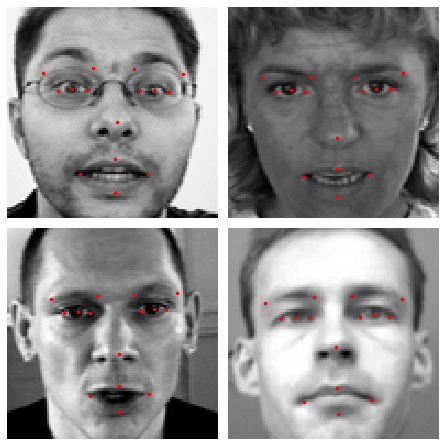

In [0]:
import pathlib

# get the checkpoint file to load the weights


model.load_weights(filepath)

# Load testing set
X_test, _ = loadData(False)

print("Test data shape == {}".format(X_test.shape))

predictions = model.predict(X_test)
fig = plt.figure(figsize=(6,6))
fig.subplots_adjust(left=0, right=1, bottom=0, top=1, hspace=0.05, wspace=0.05)
for i in range(4):
    ax = fig.add_subplot(2, 2, i + 1, xticks=[], yticks=[])
    plotData(X_test[i], predictions[i], ax)

In [0]:
!apt update
!apt install -y cmake
!pip install dlib

Note: Before proceding to next part, we need to install above packages of dlib and opencv if not installed beforehand.

## **Part3**

Here, we will test our model with real time images. To test with real time images, first we need to detect faces in the frames. Although, Face detection and landmark detection task can be carried out together using CN Networks, it involves implementation of complex algorithm like YOLO algorithm. Since, we have open sourced face detection libraries like opencv and dlib, we can use them to detect faces. Dlib's implementation works better than opencv's since it uses HOG Features trained with SVM . Opencv uses Adaboost alogorithm trained Haar-like features and it is shown to have low accuracy on various faces datasets like FDDB. 

In [0]:
import cv2
import dlib

import argparse
import time
from google.colab import files
import numpy as np


files.upload()
image = cv2.imread("test_2.jpg")
image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

fig1 = plt.figure(figsize=(20,20))
ax1 = fig1.add_subplot(1, 1, 1, xticks=[], yticks=[])

detector = dlib.get_frontal_face_detector()
rects = detector(image, 1)

for (i,rect) in enumerate(rects):
  cv2.rectangle(image, (rect.left(), rect.top()), (rect.right(), rect.bottom()), (0, 0, 255), 2);
  detection = image[rect.top():rect.bottom(), rect.left():rect.right()]
  print(rect)
  detect_copy = np.copy(detection)
  test_image = cv2.cvtColor(detection, cv2.COLOR_RGB2GRAY)
  test_image = cv2.resize(test_image,(96,96))/255
  test_image = np.expand_dims(test_image, axis=0)
  test_image = np.expand_dims(test_image, axis=3)
  predictions =  np.squeeze(model.predict(test_image))
  y_scale = (detection.shape[0])/96
  x_scale = (detection.shape[1])/96
  ax1.scatter(((predictions[0::2] * 48 + 48)*x_scale)+rect.left()+1,((predictions[1::2]*48+48)*y_scale)+rect.top()-6, 
                   marker='o', c='r', s=8)
  
ax1.imshow(image)

